# POS Tagging via Bi-directional LSTM-CNNs-CRF

In this document, I will show you how to implement a state of the art [Bi-directional LSTM-CNN-CRF architecture](http://www.aclweb.org/anthology/P16-1101) for POS tagging using pytorch.

The agenda of this implementation is as follows:
1. Processing data samples using two pytorch data primitives: [Dataset & dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
2. Replace the randomly initialized embeddings with pre-trained word embeddings: [GloVe](https://nlp.stanford.edu/projects/glove/)
3. Build up LSTM-CNNs-CRF model, this includes:
    1. character CNN encoder for char level embeddings
    2. randomly initialized word embeddings or pretrained word embeddings
    3. charCNN layer
    4. biLSTM layer
    5. CRF layer
4. Training/validating/testing.


In [180]:
import os
import re
import random

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm

[nltk_data] Downloading package punkt to /Users/xiyaguan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## I. Define parameters

In [181]:
# Hyperparameters
NUM_EPOCHS = 5
LEARNING_RATE = 0.002
DROPOUT = 0.2
EMBED_DIM = 50  # input word embedding dimension
CHAR_EMBED_DIM = 50  # = num_output_channel (number of kernels or filters) of charCNN: charator embedding dimension 
HIDDEN_DIM = 50  # The number of features in the hidden state h in LSTM layer
NUM_LAYERS = 1  # number of LSTM layers  
BIDIRECTIONAL = True  # If True, becomes a bidirectional LSTM
KERNEL_SIZE = 2  # Size of the convolving kernel (number of chars to apply a single convolution)

# GPU setting
SEED = 1334
DEVICE_ID = 0

# padding and unknown symbols and indicis for token
PAD_IDX = 0
UNK_IDX = 1
UNK = '<unk>'
PAD = '<pad>'

# padding and unknown symbols and indicis for charactors
CHAR_PAD_IDX = 0
CHAR_UNK_IDX = 1
CHAR_UNK = '<char_unk>'
CHAR_PAD = '<char_PAD>'

# beging of sentence tag and end of sentence tag
BOS = '<bos>' # CRF
EOS = '<eos>' # CRF

# hyperparameter for implementing char embedding using charCNN
# for each words, we will do pad or trauncate 
# to convert the original word into a WORD_LEN letters word.
WORD_LEN = 20

In [182]:
os.environ["CUDA_VISIBLE_DEVICES"] = f"{DEVICE_ID}"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [183]:
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

## II. Read files

In [184]:
def read_in_gold_data(filename):
    """Read in the labeled gold data into a list"""
    dataset = []
    with open(filename) as f:
        for line in f:
            tuples = [tup.split('_') for tup in line.split()]
            tokens = [tup[0].lower() for tup in tuples]
            tags = [tup[1] for tup in tuples]
            dataset.append((tokens, tags))
    return dataset

In [185]:
# from google.colab import drive
# drive.mount('/content/drive')
# train_filepath = os.path.join(os.getcwd(), "train/train.tagged")
# train_filepath = "/content/drive/MyDrive/PA3_Starter_code/train/train.tagged"
# train_filepath = "/content/drive/MyDrive/PA3_Starter_code/train/ptb_02-21.tagged"
train_filepath = os.path.join(os.getcwd(), "train/ptb_02-21.tagged")
training = read_in_gold_data(train_filepath)
print(len(training))
dev_filepath = os.path.join(os.getcwd(), "dev/ptb_22.tagged")
# dev_filepath = "/content/drive/MyDrive/PA3_Starter_code/dev/ptb_22.tagged"
dev = read_in_gold_data(dev_filepath)

39832


## III. Build up tokens/tags/chars vocab

In [186]:
tokens, tags, chars = set(), set(), set()

In [187]:
word_lens = []
for sent in training:
    tokens.update(sent[0])
    tags.update(sent[1])
    for word in sent[0]:
        chars.update(word)
        word_lens.append(len(word))
a = torch.tensor(word_lens)
torch.mean(a.float())

tensor(4.4634)

In [188]:
tokens, tags, chars = sorted(tokens), sorted(tags), sorted(chars)
# tags

In [189]:
tokens = [PAD, UNK] + tokens
token2idx = {word: i for i, word in enumerate(tokens)}
idx2token = {i: word for i, word in enumerate(tokens)}
token_vocab = (token2idx, idx2token)
# len(tokens)

In [190]:
tags = [BOS, EOS] + tags
tag2idx = {word: i for i, word in enumerate(tags)}
idx2tag = {i: word for i, word in enumerate(tags)}
tag_vocab = (tag2idx, idx2tag)
num_tags = len(tags)
TAG_PAD_IDX = num_tags
print(tags)

['<bos>', '<eos>', '#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [191]:
chars = [CHAR_PAD, CHAR_UNK] + chars
char2idx = {char: i for i, char in enumerate(chars)}
idx2char = {i: char for i, char in enumerate(chars)}
char_vocab = (char2idx, idx2char)
# chars

## IV. Creating a Custom Dataset and Dataloader
1. Customize Dataset
2. Determine bucket boundaries
3. Customize batch sampler
4. Customize collate function
5. Customize Dataloader

### 1. Customize Dataset

In [192]:
from torch.utils.data import Dataset

In [193]:
class POStagging(Dataset):
    def __init__(self, data, token2idx, tag2idx):
        self.data = data
        self.token2idx = token2idx
        self.tag2idx = tag2idx

    def featurize(self, tokens, tags):
        normalized_tokens = [x if x in self.token2idx else UNK for x in tokens]
        featurized_tokens = [self.token2idx[x] for x in normalized_tokens]
        featurized_tags = [self.tag2idx[x] for x in tags]
        return featurized_tokens, featurized_tags

    def __getitem__(self, idx):
        tokens, tags = self.data[idx]
        featurized_tokens, featurized_tags = self.featurize(tokens, tags)

        x = torch.tensor(featurized_tokens, dtype=torch.int64)
        y = torch.tensor(featurized_tags, dtype=torch.int64)
        return x, y, tokens, tags

    def __len__(self):
        return len(self.data)


In [194]:
training_dataset = POStagging(training, token2idx, tag2idx)
dev_dataset = POStagging(dev, token2idx, tag2idx)

### 2. Choosing bucket boundaries

In [195]:
import numpy as np
import matplotlib.pyplot as plt

In [196]:
lens = np.array([len(x[0]) for x in training])
np.min(lens), np.mean(lens), np.max(lens)

(1, 23.850873669411527, 141)

In [197]:
# plt.figure()
# plt.grid(True)
# plt.hist(lens, bins=10)
# plt.show()

In [198]:
# inclusive for endpoints
# bucket ranges: [:10], [10:20], [20:30], [30:40], [40:60], [60:]
buckets = [10, 20, 30, 40, 60, 80]

In [199]:
# plt.figure(figsize=[100, 25])
# plt.subplot(121)
# plt.hist(lens, bins=10)
# plt.grid(True)
# plt.title('Distribution of Lengths')
# plt.show()

In [200]:
# plt.figure(figsize=[100, 25])
# plt.subplot(122)
# plt.hist(lens, bins=[1]+buckets+[100], align='mid')
# plt.grid(True)
# plt.title('Bucketed Lengths')
# plt.show()

### 3. Customize batch sampler

In [201]:
def batchify(iterable, n):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx: min(ndx + n, l)]

In [202]:
class CustomBucketSampler:
    def __init__(self, dataset, buckets, batch_size):
        self.dataset = dataset
        self.buckets = buckets  
        self.num_buckets = len(buckets) + 1  # 6
        self.batch_size = batch_size
    
    def __len__(self):
        return len(self.dataset)
    
    def __iter__(self):
        # 1. collect lengths (and corresponding ids) of all data instances
        idx_lens = [(i, len(x[0])) for i, x in enumerate(self.dataset)]
        
        # 2. sort by lengths
        idx_lens = sorted(idx_lens, key=lambda x:x[1])
        
        # 3. create empty buckets
        buckets = [[] for _ in range(self.num_buckets)]
        
        # 4. assign data to appropriate buckets
        for i, l in idx_lens:
            for j, bucket_limit in enumerate(self.buckets):
                if l <= bucket_limit: # if length falls within a certain boundary
                    buckets[j].append(i)
                    break
            # for data whose length is greater than the max boundary (9), assign to last bucket
            if l > bucket_limit: # `bucket_limit` guaranteed to be 9
                buckets[-1].append(i)
                
        # make sure the numbers match up
        assert sum([len(x) for x in buckets]) == len(self.dataset)
        
        # 5. create batches in each bucket while shuffling
        batches = []
        for bucket in buckets: 
            random.shuffle(bucket)
            for batch in batchify(bucket, self.batch_size):
                batches.append(batch)

        # 6. shuffle batches and finally yield
        random.shuffle(batches)
        for batch in batches:
            yield batch

In [203]:
batch_size = 5
train_sampler = CustomBucketSampler(training, buckets, batch_size=batch_size)

In [204]:
from torch.nn.utils.rnn import pad_sequence

### 4. Customize collate function

In [205]:
def collate_fn(batch):  
#     print(batch[0][0])
#     print(batch[0][1])
#     print(batch[0][2])
#     print(batch[0][3])
    featurized_tokens, featurized_tags, row_tokens, row_tags = zip(*batch)
#     print(f"featurized_tokens:{featurized_tokens}")
#     print(f"featurized_tags:{featurized_tags}")
#     print(f"row_tokens:{type(row_tokens)}")
#     print(f"row_tags:{row_tags}")
    lens = [len(x) for x in featurized_tokens]
#     print(f"lens:{lens}")
    tokens = pad_sequence(featurized_tokens, batch_first=True, padding_value=PAD_IDX)
    tags = pad_sequence(featurized_tags, batch_first=True, padding_value=TAG_PAD_IDX)
    return tokens, tags, row_tokens, row_tags, torch.tensor(lens)

### 5. Customize Dataloader

In [206]:
from torch.utils.data import DataLoader

In [207]:
train_dl = DataLoader(training_dataset, collate_fn=collate_fn, batch_sampler=train_sampler)
dev_dl = DataLoader(dev_dataset, batch_size=len(dev_dataset), collate_fn=collate_fn)
# tokens, tags, row_tokens, row_tags, lens = next(iter(dev_dl))
# print(tokens.shape)
# print(tags.shape)
# print(lens.shape)
# print(len(row_tokens))
# x, y, tokens, tags
# for i, batch in enumerate(train_dl):
#     print(batch)
# #     print(f"featurized_tokens:{batch[0][0]}")
# #     print(f"featurized_tags:{batch[0][1]}")
# #     print(f"row_tokens:{batch[0][2]}")
# #     print(f"row_tags:{batch[0][3]}")
# #     print(f"lens:{batch[0][4]}")
#     if i == 0:
#         break

## V. Set up pretrained word embeddings -- Glove

In [208]:
## Code the read in pre-trained word embeddings
def glove2dict(glove_path,emb_dim=50):
    """Read in glove embeddings and create a dictionary"""
    glove_dict = {}
    if emb_dim == 50:
        fname= "glove.6B.50d.txt"
    elif emb_dim == 100:
        fname="glove.6B.100d.txt"
    elif emb_dim == 200:
        fname="glove.6B.200d.txt"
    elif emb_dim == 300:
        fname="glove.6B.300d.txt"
    else:
        print("Inappropriate glove size chosen, using 50")
        fname="glove.6B.50d.txt"
    with open(f'{glove_path}/{fname}', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            vect = np.array(line[1:])
            glove_dict[word] = vect
    return glove_dict

In [209]:
def create_glove_embeddings(glove_path, token2idx, emb_dim=50):
    """create the glove embeddings for a target dictionary"""
    glove = glove2dict(glove_path, emb_dim)
    matrix_len = len(token2idx) 
  
    weights_matrix = np.zeros((matrix_len, emb_dim))
    pad_weight = np.zeros((1, emb_dim))
    words_not_found = 0
    
    for word, idx in token2idx.items():
        if word == PAD:
            weights_matrix[idx] = pad_weight
        
        else:
            try:
                weights_matrix[idx] = glove[word]
            except KeyError:
                weights_matrix[idx] = np.random.normal(scale=0.6, size=(1, emb_dim))
                words_not_found += 1
    return torch.from_numpy(weights_matrix).float(), words_not_found

In [210]:
glove_path = os.path.join(os.getcwd(), "embedding")
# glove_path = "/content/drive/MyDrive/PA3_Starter_code/embedding"
weights_matrix, words_not_found = create_glove_embeddings(glove_path, token2idx, EMBED_DIM)
print(f"words not found in glove:{words_not_found}")

words not found in glove:5749


## VI. Build up model
1. charCNN layer (customize charCNNEmbeddings)
2. biLSTM layer
3. CRF layer
4. biLSTM_greedy model (without CRF layer)
5. biLSTM_CRF model (with CRF layer)

### 1. charCNN layer

In [211]:
class CharCNNEmbeddings(nn.Module):
    def __init__(self, char_input_dim, char_embed_dim, char_pad_idx, device):
        super().__init__()
        self.embeddings = nn.Embedding(char_input_dim, char_embed_dim, padding_idx=char_pad_idx, device=device)
    
    def forward(self, x, row_x, lens):
        # x.shape: [batch_size, seq_length]
        # row_x: list of list of words [I idx(l), idx(o), idx(v), idx(e), 0,0, 0 you], [I hate], []
        
        
        # return shape: [batch_size, seq_length, char_embeddings_dim, word_len]
        batch_size, seq_length = x.size()
        # input_tensor.shape [batch_size, max_seq_length, WORD_LEN]
        input_tensor = torch.zeros(batch_size, seq_length, WORD_LEN, dtype=torch.long)
        for i in range(batch_size):
            for j in range(lens[i]):
                for k, char in enumerate(row_x[i][j][:WORD_LEN]):
                    if char in char2idx:
                        input_tensor[i, j, k] = char2idx[char]
                    else:
                        input_tensor[i, j, k] = CHAR_UNK_IDX
        char_embeddings_features = self.embeddings(input_tensor)
        # [batch_size, max_seq_length, char_embeddings_dim, fixed_word_len=20]
        return char_embeddings_features.permute(0, 1, 3, 2)

In [212]:
class CharCNN(nn.Module):
    def __init__(self, char_input_dim, char_embed_dim, hidden_dim, kernel_size, char_pad_idx, device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = CharCNNEmbeddings(char_input_dim, char_embed_dim, char_pad_idx, device)
        self.conv = nn.Conv1d(char_embed_dim, hidden_dim, kernel_size)
        
    def forward(self, x, row_x, lens):
        # [batch_size, seq_length, char_embeddings_dim, word_len]
        embeds = self.embedding(x, row_x, lens)
        batch_size, seq_length, char_embed_dim, word_len = embeds.size()
        
        max_pooling_output = torch.zeros(batch_size, seq_length, self.hidden_dim)
        for i in range(batch_size):
            conv = F.relu(self.conv(embeds[i]))          
            conv = F.max_pool1d(conv, conv.shape[-1])
            conv = torch.squeeze(conv, -1)            
            max_pooling_output[i] = conv
            
        # char_embeddings_dim, word_len   -> (50, )
        return max_pooling_output  # [[batch_size, seq_length, embed_dim]
        

In [213]:
# char_input_dim = len(chars)
# char_embed_dim = CHAR_EMBED_DIM
# kernel_size = 2
# char_pad_idx = CHAR_PAD_IDX
# hidden_dim = 50
# # emb = CharCNNEmbeddings(char_input_dim, CHAR_EMBED_DIM, CHAR_PAD_IDX)
# x = torch.tensor([[2, 3, 4, 0], [2, 5, 0, 0], [2, 6, 3, 4]])
# row_x = [['i', 'love', 'you'], ['i', 'what'], ['i', 'dont', 'love', 'you']]
# lens = torch.tensor([3, 2, 4])
# # emb(x, row_x, lens)
# cnn = CharCNN(char_input_dim, char_embed_dim, hidden_dim, kernel_size, char_pad_idx)
# cnn(x, row_x, lens)


### 2. biLSTM layer

In [214]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, char_input_dim, output_dim, device, token_pad_idx, char_pad_idx, pretrained_weights):
        super().__init__()
        '''
        1. word_embedding
        '''
#         if pretrained_weights == None:
        self.embedding = nn.Embedding(input_dim, EMBED_DIM, padding_idx=token_pad_idx)
#         else:
#         print(pretrained_weights.shape)
        # self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
            
        '''
        2. char-CNN embedding
        '''
#         self.charembedding = CharCNN(char_input_dim, CHAR_EMBED_DIM, EMBED_DIM, KERNEL_SIZE, char_pad_idx, device)
        self.lstm = nn.LSTM(EMBED_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS, batch_first=True, bidirectional=BIDIRECTIONAL)
        self.linear = nn.Linear(HIDDEN_DIM*2 if BIDIRECTIONAL else HIDDEN_DIM, output_dim) # project to vocab space
        self.dropout = nn.Dropout(DROPOUT)
        self.device = device
        
    def init_hidden(self, batch_size):
        direction_multiplier = 2 if BIDIRECTIONAL else 1
        return (torch.randn(direction_multiplier * NUM_LAYERS, batch_size, HIDDEN_DIM, device=self.device), # h0
                torch.randn(direction_multiplier * NUM_LAYERS, batch_size, HIDDEN_DIM, device=self.device)) # c0
        
    def forward(self, x, rows_x, lens):
        '''
        1. word_embedding
        '''
        token_embed = self.embedding(x)  # shape: [batch_size, seq_length, emb_dim]
        '''
        2. char-CNN embedding
        '''
#         char_embed = self.charembedding(x, rows_x, lens)
#         embed = token_embed + char_embed
#         embed = torch.cat((token_embed, char_embed), dim=2)
        embed = self.embedding(x)
        embed = self.dropout(embed)
        batch_size = embed.shape[0]
        self.hidden = self.init_hidden(batch_size)
        outputs, _ = self.lstm(embed, self.hidden)
        outputs = self.linear(outputs)
        return outputs 


### 3. CRF layer

In [215]:
class CRF(nn.Module):
    """TODO: Impelement CRF forward, score and viterbi functions"""
    def __init__(self, tgt_vocab, device):
        super().__init__()
        self.tag2idx, self.idx2tag = tgt_vocab
        self.tag_size = len(self.tag2idx)
        self.device = device
        
        # transition matrix
        self.start_transitions = nn.Parameter(torch.empty(num_tags, device=self.device))
        self.end_transitions = nn.Parameter(torch.empty(num_tags, device=self.device))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags, device=self.device))
        
        self.reset_parameters()
        # print(self.start_transitions.is_cuda)
        # print(self.end_transitions.is_cuda)
        # print(self.transitions.is_cuda)
    
    def reset_parameters(self):
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)
    
    def forward(self, feats, lens):
        emissions = feats.transpose(0, 1)
        # print("I am here")
        # print(emissions.is_cuda)
        seq_length, batch_size = emissions.shape[0], emissions.shape[1]
        # build up tag mask
        # print(f"seq_length.is_cuda:{seq_length.is_cuda:}")
        # print(f"batch_size.is_cuda:{batch_size.is_cuda:}")
        # mask = torch.empty(seq_length, device=self.device)
        # torch.arange(seq_length).expand(lens.shape[0], seq_length).cuda() < lens.unsqueeze(1)
        # print(lens.unsqueeze(1).is_cuda)
        # mask = (torch.arange(seq_length).expand(lens.shape[0], seq_length) < lens.unsqueeze(1)).cuda()
        # mask = torch.arange(seq_length).expand(len(lens), seq_length) < lens.unsqueeze(1)
        # mask.cuda()
        mask = torch.transpose(torch.arange(seq_length).expand(lens.shape[0], seq_length) < lens.unsqueeze(1), 0, 1)
        # print(mask)
        # print("I am here at mask")
        # print(f"mask.is_cuda{mask.is_cuda}")
        score = self.start_transitions + emissions[0]
        
        for i in range(1, seq_length):
            broadcast_score = score.unsqueeze(2)
            broadcast_emissions = emissions[i].unsqueeze(1)
            next_score = broadcast_score + self.transitions + broadcast_emissions
            next_score = torch.logsumexp(next_score, dim=1)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            
        score += self.end_transitions
        res = torch.logsumexp(score, dim=1)
        return res
        
        
    def score(self, feats, tags, lens):
        # emissions.shape: [seq_len, batch_size, num_tags]
        # tags.shape: [seq_len, batch_size]
        # lens.shape: [batch_size, ]
        # emissions
        emissions = feats.transpose(0, 1)
        tags = tags.transpose(0, 1)
        seq_length, batch_size = tags.size()
        
        # build up tag mask
        mask = (tags != TAG_PAD_IDX)
        # gold tags 
        tags = tags * mask
        
        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]
        
        for i in range(1, seq_length):
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]
        
        seq_ends = lens - 1
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        score += self.end_transitions[last_tags]
        return score
    
    def viterbi(self, feats, lens):
        emissions = feats.transpose(0, 1)
        seq_length, batch_size = emissions.shape[0], emissions.shape[1]
        # build up tag mask
        # print(torch.arange(seq_length).expand(lens.shape[0], seq_length).cuda().is_cuda)
        # print(lens.unsqueeze(1).is_cuda)
        mask = torch.transpose(torch.arange(seq_length).expand(lens.shape[0], seq_length) < lens.unsqueeze(1), 0, 1)
        
        score = self.start_transitions + emissions[0]
        history = []
        
        for i in range(1, seq_length):
            broadcast_score = score.unsqueeze(2)
            broadcast_emission = emissions[i].unsqueeze(1)
            next_score = broadcast_score + self.transitions + broadcast_emission
            next_score, indices = next_score.max(dim=1)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)
        
        score += self.end_transitions
        seq_ends = lens - 1
#         seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []
        
        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)
        return best_tags_list
        

### 4. biLSTM_greedy model

In [216]:
class  BiLSTM_greedy(nn.Module):
    def __init__(self, input_dim, char_input_dim, output_dim, tgt_vocab, device, token_pad_idx, char_pad_idx, pretrained_weights):
        super().__init__()
        self.lstm = BiLSTM(input_dim, char_input_dim, output_dim, device, token_pad_idx, char_pad_idx, pretrained_weights)

    
    def neg_log_likelihood(self, src, row_src, tgt, lens):
        """Compute negative log likelihood given sentence and gold POS labels"""
        feats = self.lstm(src, row_src, lens)  # torch.Size([5, 56, 47]); tgt.shape:torch.Size([5, 56])
        criterion = nn.CrossEntropyLoss(ignore_index=TAG_PAD_IDX)
        predictions = feats.view(-1, feats.shape[-1])
        tags = tgt.view(-1)
        loss = criterion(predictions, tags)
        return loss

    def forward(self, src, row_src, lens):
        """Tag a single sentence"""
        feats = self.lstm(src, row_src, lens)
        return torch.argmax(feats, dim=2)


In [217]:
# seq_length = 3
# lens = torch.tensor([3, 4, 5])
# (torch.arange(seq_length).expand(lens.shape[0], seq_length) < lens.unsqueeze(1)).cuda()

### 5. biLSTM_CRF model

In [218]:
class  BiLSTM_CRF(nn.Module):
    def __init__(self, input_dim, char_input_dim, output_dim, tgt_vocab, device, token_pad_idx, char_pad_idx, pretrained_weights):
        super().__init__()
        self.lstm = BiLSTM(input_dim, char_input_dim, output_dim, device, token_pad_idx, char_pad_idx, pretrained_weights)
        self.crf = CRF(tgt_vocab, device=device)
    
    def neg_log_likelihood(self, src, row_src, tgt, lens):
        """Compute negative log likelihood given sentence and gold POS labels"""
        feats = self.lstm(src, row_src, lens)
        # print(feats.is_cuda)
        forward_score = self.crf(feats, lens)
        # print(f"forward_score.is_cuda:{forward_score.is_cuda:}")
        gold_score = self.crf.score(feats, tgt, lens)
        # print(f"gold_score.is_cuda:{gold_score.is_cuda:}")
        return torch.sum(forward_score - gold_score)

    def forward(self, src, row_src, lens):
        """Tag a single sentence"""
        feats = self.lstm(src, row_src, lens)
        out = self.crf.viterbi(feats, lens)
        return out    

## VII. Training

In [219]:
input_dim = len(tokens)
output_dim = len(tags)
char_input_dim = len(chars)

In [220]:
# input_dim, char_input_dim, output_dim, tgt_vocab, device, token_pad_idx, char_pad_idx, pretrained_weights):
model = BiLSTM_greedy(input_dim, char_input_dim, output_dim, tag_vocab, device, PAD_IDX, CHAR_PAD_IDX, weights_matrix)
# model = BiLSTM_CRF(input_dim, char_input_dim, output_dim, tag_vocab, device, PAD_IDX, CHAR_PAD_IDX, weights_matrix)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

In [221]:
def eval_model(devset, model):
    """Given a development set and a model, compute the accuracy of the model prediction
    on the development set"""
    model.eval()
    total_tokens = 0
    correct = 0
    with torch.no_grad():
        src, tgt, row_src, row_tgt, lens = next(iter(dev_dl))
        src = src.to(device)
        tgt = tgt.to(device)
        lens = lens.to(device)
    #             row_src = row_src.to(device)
    #             row_tgt = row_tgt.to(device)

        pred = model(src, row_src, lens)
        for k in range(src.shape[0]):
            length = lens[k]
#             correct += (torch.tensor(pred[k]) == tgt[k, :length]).sum()
            correct += (pred[k, :length] == tgt[k, :length]).sum()
            # print(pred[k, :length])
            # print(tgt[k, :length])
            # print([idx2tag[tag.item()] for tag in pred[i, :length]])
            # print([idx2tag[tag.item()] for tag in tgt[i, :length]])
            total_tokens += length
    dev_acc = correct/total_tokens
    return dev_acc

In [222]:
do_validation = 2
for i in range(NUM_EPOCHS):
    epoch_loss = 0.
    num_correct = 0
    num_tokens = 0

    model.train()
    for j, batch in tqdm.tqdm(enumerate(train_dl), desc=f'[Training {i+1}/{NUM_EPOCHS}]'):
        src, tgt, row_src, row_tgt, lens = batch
        src = src.to(device)
        tgt = tgt.to(device)
        lens = lens.to(device)
        # row_src = row_src.to(device)
        # row_tgt = row_tgt.to(device)
        
        model.zero_grad()
        batch_size = src.shape[0]
        
        loss = model.neg_log_likelihood(src, row_src, tgt, lens)
        epoch_loss += loss

        loss.backward()
        optimizer.step()
        
        
        pred = model(src, row_src, lens)
        batch_size = src.shape[0]
        
        for k in range(batch_size):
            length = lens[k]

#             num_correct += (torch.tensor(pred[k]) == tgt[k, :length]).sum()
            num_correct += (pred[k, :length] == tgt[k, :length]).sum()
            num_tokens += length
    epoch_acc = num_correct.item() / num_tokens
    print("Training Epoch # {} Loss: {:.2f} Acc: {:.2f}".format(i+1, epoch_loss.item(), epoch_acc))
    

    # validation on dev dataset
    if i % do_validation == 0:
    #     model.eval()
    #     total_tokens = 0
    #     correct = 0
    #     with torch.no_grad():
    #         src, tgt, row_src, row_tgt, lens = next(iter(dev_dl))
    #         src = src.to(device)
    #         tgt = tgt.to(device)
    #         lens = lens.to(device)
    # #             row_src = row_src.to(device)
    # #             row_tgt = row_tgt.to(device)

    #         pred = model(src, row_src, lens)
    #         for k in range(src.shape[0]):
    #             length = lens[k]
    #             # correct += (torch.tensor(pred[k]).cuda() == tgt[k, :length]).sum()
    #             correct += (pred[i, :length] == tgt[i, :length]).sum()
    #             total_tokens += length
    #     dev_acc = correct/total_tokens
        # return correct/total_tokens
        dev_acc = eval_model(next(iter(dev_dl)), model)
        print("Acc on dev: {:.2f}".format(dev_acc))


[Training 1/5]: 7969it [03:48, 34.91it/s]


Training Epoch # 1 Loss: 4258.29 Acc: 0.85
Acc on dev: 0.92


[Training 2/5]: 7969it [04:29, 29.59it/s]


Training Epoch # 2 Loss: 1943.03 Acc: 0.93


[Training 3/5]: 7969it [04:29, 29.59it/s]


Training Epoch # 3 Loss: 1490.60 Acc: 0.94
Acc on dev: 0.94


[Training 4/5]: 7969it [04:27, 29.79it/s]


Training Epoch # 4 Loss: 1257.75 Acc: 0.95


[Training 5/5]: 7969it [04:24, 30.10it/s]


Training Epoch # 5 Loss: 1117.18 Acc: 0.96
Acc on dev: 0.95


## Testing on test dataset

In [230]:

def read_in_plain_data(filename):
    """Read in plain text data for sequence labeling, assuming a one-sentence-per-line format"""
    with open(filename) as f:
        lines = f.readlines()
        lines = [line.split() for line in lines]
    return lines

def featurize(line):
    normalized_tokens = [x if x in token2idx else UNK for x in line]
    featurized_tokens = [token2idx[x] for x in normalized_tokens]
    return featurized_tokens

def padding(data):
    featurized_lines = []
    for line in data:
        featurized_lines.append(torch.tensor(featurize(line), dtype=torch.int64))
    lens = [len(x) for x in featurized_lines]
#     print(featurized_lines)
    tokens = pad_sequence(featurized_lines, batch_first=True, padding_value=PAD_IDX)
    return tokens, torch.tensor(lens)


test_filepath = os.path.join(os.getcwd(), "dev/ptb_23.snt")
dev = read_in_gold_data(test_filepath)
print(dev)
# print(dev[:99])
gold = [tag for seq, tag in dev]
# print(gold[:99])


# test_filepath = "/content/drive/MyDrive/PA3_Starter_code/dev/ptb_22.snt"
test_filepath = os.path.join(os.getcwd(), "dev/ptb_22.snt")
data = read_in_plain_data(test_filepath)
tokens, lens = padding(data)

# with torch.no_grad():
#   pred = model(tokens.to(device), data, lens.to(device))
# print(len(pred))
# print(idx2tag)
# for line in pred:
#     print([idx2tag[tag] for tag in line])
# return correct/total_tokens




IndexError: list index out of range

In [224]:
def compare_tagseq(goldseq, predicted_seq):
    """Compare two sequences and output the length of the sequence 
    and the number of tags they share. A helper function to the evaluation function"""
    pairs = zip(goldseq, predicted_seq)
    correct = len([1 for pair in pairs if pair[0]== pair[1]])
    return len(goldseq), correct

    
i = 0
total = 0
correct = 0
for tags, line, gol in zip(pred, data, gold):
    i += 1
    # print(gol)
    # for tag in tags:
    #   print(tag)
    #   print()
    # print([idx2tag[tag.item()] for tag in tags])
    # print(line)
    # print(gol)
    cnt, cor = compare_tagseq(gol, [idx2tag[tag] for tag in tags])
    # print(cnt, cor)
    total += cnt
    correct += cor
    # print(line)
    # print([idx2tag[tag] for tag in tags])
    # print(gol)
    # print()
    # if i == 99:
    #   break
print(correct/total)

KeyError: tensor(16)

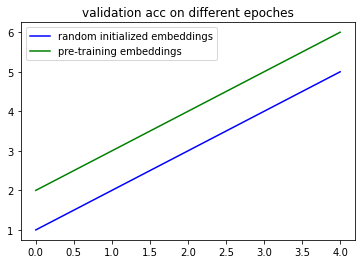

In [228]:
import matplotlib.pyplot as plt
dev_result = [1, 2, 3, 4, 5]
dev_result2 = [2, 3, 4, 5, 6]
plt.figure()
plt.plot(list(range(NUM_EPOCHS)), dev_result, 'b', label='random initialized embeddings')
plt.plot(list(range(NUM_EPOCHS)), dev_result2, 'g', label='pre-training embeddings')
plt.title('validation acc on different epoches')
plt.legend()
plt.show()